# Introducción a la colecta de datos con cámaras digitales y Vehículos Aéreos No Tripulados

El presente notebook, tiene como fin presentar el uso de un script que contiene diferentes clases para modelar: 
- Cámara digital (sensor óptico-electrónico)
- Ruta de vuelo con un RPAS
- Lidar (aun en desarollo)

## Importar las librerías y módulos necesarios

Descargar el repositorio de GitHub, descomprimirlo y almacenar su ruta como string en una variable, para importarlo.

In [1]:
import sys # System specific configuration
from pathlib import Path

# you can add to the Python path at runtime:
git_repo = 'E:/open-forestal-master' # windows, '/home/open-forestal-master' # linux
repo_path = Path(git_repo) 
module_path  = repo_path / 'Script' 

sys.path.insert(0, str(module_path))

import FlightPath as fp

## Características de la Cámaras Digitales 

Los dos componentes principales de cualquier cámara digital con sensor de cuadro (digital frame cameras): son el sensor de imagen (image sensor) y el lente (lens), y los cálculos relacionados con la óptica se basan en las dimensiones y características de estos dos elementos. Los sensores de imagen tienen una matriz de celdas sensibles (photosised) que convierte las ondas de luz en señales eléctricas que se miden e interpretan para producir una matriz de valores que forman la imagen digital. Las lentes son dispositivos de transmisión óptica utilizados para enfocar o dispersar la luz por medio de la refracción.

El modelo de lente delgada (thin-lens model) simplifica los cálculos de trazado de rayos al ignorar los efectos ópticos debido al grosor de la lente, se utiliza con el propósito de cubrir conceptos básicos de óptica e imagen.

A continuación presentamos los términos fundamentales referidos a los sistemas de imagen:

- **Tamaño del sensor (Sensor size, image sensor format) :** Las dimensiones del área activa del sensor de la cámara. Este parámetro normalmente se especifica como dimensiones físicas horizontales y verticales. El tamaño del sensor se puede calcular conociendo el número de píxeles horizontales y verticales en el sensor y el tamaño de un píxel.

- **Distancia focal (Focal length - $\text{f}$ ) :** es la distancia desde el centro óptico de la lente hasta el plano del sensor de imagen cuando la lente está enfocada al infinito, generalmente expresada en milímetros.

- **Campo de visión (Field of View - FOV) :** el área visible de una escena dada que es capturada por el sensor de imagen de la cámara. El FOV a veces se expresa como el tamaño angular del cono de visión y se denomina ángulo de visión (angle of view), y se puede medir horizontal, vertical o diagonalmente.

- **Abertura (Aperture, f-number) :** el tamaño de la abertura por la que entra la luz en la cámara. Junto con la distancia focal, define el ángulo del cono de luz que se enfoca en el plano del sensor.

- **Velocidad de obturación (Shutter speed) :** es la velocidad a la que se cierra el obturador de la cámara.

- **Profundidad de campo (Depth of Field - DOF) :** el rango entre las distancias de trabajo máximas y mínimas donde es posible mantener un enfoque aceptable, es también la cantidad total de movimiento del objeto en el eje óptico permitido mientras se mantiene el enfoque.

- **Ampliación primaria (Primary Magnification - PMAG) :** se define como la relación entre el tamaño del sensor y el campo de visión.

## Orientación "interna" y "externa" 

Son términos que se utilizan en el campo de la fotogrametría.

La orientación interna de una cámara se ocupa de sus parámetros internos, principalmente las características de la lente y el sensor de imagen. Se centra en las propiedades intrínsecas y la calibración de la cámara, se consideran los siguientes parámetros:

- Distancia focal (Focal length)
- Tamaño de píxel (Pixel Size)
- Punto Principal (Principal Point)
- Distorsión de la lente (Lens Distortion)

La orientación externa se refiere a la posición y orientación de la cámara en el mundo real con respecto al objeto fotografiado, se consideran los siguientes parámetros:

- Posición: las coordenadas 3D (x, y, z) de la ubicación de la cámara en un sistema de referencia.
- Orientación: normalmente representada como tres ángulos (balanceo, cabeceo y guiñada) o como una matriz de rotación. Esta información indica la dirección hacia la que apunta la cámara.

### Altum PT de Micasense

Esta cámara integra los siguientes sensores : cinco bandas multiespectrales, térmico y pancromático. Tambien debemos tener en cuenta que el receptor GNSS y la unidad de medición inercial se integran comúnmente a los sensores pasivos y activos, y dicha  información referente a cada tipo de sensor e imagen capturada está registrado en los metadatos.

In [2]:
# Interior Orientation 

# Lens and Multispectral Imager Information
fl = 8 # focal lenght in milimeters
sw = 7.12 # sensor Width in milimeters
sh = 5.33 # sensor Heigth in milimeters
Xpx = 2064 # the image width in pixels
Ypx = 1544 # the image height in pixels

In [3]:
# Exterior orientation 

h = 100 # flying height above ground in meters (m)
E, N = 418553.52, 8632067.97 # UTM coordinates (easting and northing) from EXIF:GPSLatitude,GPSLongitude
crs18Sepgs = 32718 # CRS UTM 18S
xgimbal, ygimbal, zgimbal = 0, 0, 325 # Roll, Pitch, Yaw in degree from EXIF

### Instanciar la clase para crear un objeto que modele cada sensor de la cámara Altum PT de Micasense.

#### Sensor Multiespectral

In [4]:
altumPT_ms = fp.CameraUAV(sw, sh, Xpx, Ypx, fl) 

#### Sensor Térmico y Sensor Pancromático

In [5]:
# Lens and Panchromatic Imager Information
fl, sw, sh, Xpx, Ypx = 16.3, 14.18, 10.37, 4112, 3008
print(fl, sw, sh, Xpx, Ypx)
altumPT_pc = fp.CameraUAV(sw, sh, Xpx, Ypx, fl)

# Lens and Thermal Imager Information
fl, sw, sh, Xpx, Ypx = 4.5, 3.84, 3.07, 320, 256
print(fl, sw, sh, Xpx, Ypx)
altumPT_tr = fp.CameraUAV(sw, sh, Xpx, Ypx, fl)

16.3 14.18 10.37 4112 3008
4.5 3.84 3.07 320 256


### Mostrar atributos

In [6]:
altumPT_ms.focalLen

8

**Distancia entre píxeles (Pixel pitch):** tambien llamado tamaño del pixel (pixel size), es la distancia desde el centro de un píxel hasta el centro del siguiente medido en micrómetros ($\mu m$). Se puede calcular como la relación entre las dimensiones del sensor y el número de píxeles registrados, con la siguiente fórmula:

\begin{equation}
\text{Pixel pitch} = \frac {\text{sensor size} \left( mm \right)}{\text{sensor resolution} \left( pixels \right)}
\end{equation}

In [7]:
altumPT_ms.pixelPitch_(view=True) # 3.75 pixel size in microns

*********************************** Results ***********************************
Pixel pitch X (um): 3.45 
Pixel pitch Y (um): 3.45
Pixel side ratio is: 1.0


(3.45, 3.45)

**Campo de visión (Field of View - FoV) :** el ángulo sólido a través del cual un elemento detector (un sensor de píxeles) es sensible a la radiación electromagnética en un momento dado.

\begin{equation}
FOV = 2\times \arctan \left({\frac {\text{sensor size}}{2f}}\right)
\end{equation}

In [8]:
altumPT_ms.FoV_(view=True)

*********************************** Results ***********************************
Horizontal Field of View (°): 48.0 
Vertical Field of View (°): 36.8 
Diagonal Field of View (°): 58.1 
Normal angle (up to 75°)


(48.0, 36.8, 58.1)

### Llamar a los métodos

**Ground Sampling Distance-GSD :**  determina la escala de la imagen o la resolución del terreno en la imagen, influenciado por: el tamaño de la matriz de pixéles, distancia focal de la lente y altitud de vuelo (sobre el suelo).

In [9]:
altumPT_ms.GSD(h, view=True)

*********************************** Results ***********************************
Altitude: 100 

GSD X (cm/px): 4.312015503875969 
GSD Y (cm/pxl): 4.3125


(4.312015503875969, 4.3125)

Crear un gráfico para mostrar la relación entre GSD y altura de vuelo para los distintos sensores de la cámara Altum PT.

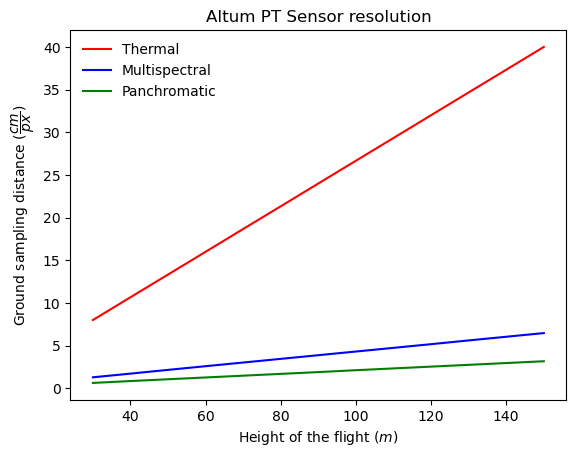

In [10]:
import numpy as np # package for matrix data structure

height_flight_m = np.arange(30, 160, 10)
resolution_cm_pixel_ms = [round(altumPT_ms.GSD(altitude=h, view=False)[0], 2) for h in height_flight_m]
resolution_cm_pixel_ms

resolution_cm_pixel_pc = [round(altumPT_pc.GSD(altitude=h, view=False)[0], 2) for h in height_flight_m]
resolution_cm_pixel_pc

resolution_cm_pixel_tr = [round(altumPT_tr.GSD(altitude=h, view=False)[0], 2) for h in height_flight_m]
resolution_cm_pixel_tr


import pandas as pd # for data frame and analysis
import matplotlib.pyplot as plt # ploting

# data
df = pd.DataFrame({'h':height_flight_m, 'gsd_ms':resolution_cm_pixel_ms,
                   'gsd_pc':resolution_cm_pixel_pc, 'gsd_tr':resolution_cm_pixel_tr})
df

# Object Oriented plot
fig = plt.figure()
ax = plt.axes()
ax.plot(df['h'], df['gsd_tr'], '-r', label='Thermal');
ax.plot(df['h'], df['gsd_ms'], '-b', label='Multispectral');
ax.plot(df['h'], df['gsd_pc'], '-g', label='Panchromatic');
ax.set_title('Altum PT Sensor resolution')
ax.set_xlabel('Height of the flight $(m)$')
ax.set_ylabel('Ground sampling distance $(\dfrac{cm}{px})$')
ax.legend(loc='upper left', frameon=False)


**Ground Field of View :** estima la longitud de los lados de la huella de la imagen en el terreno, a partir de las caracteristicas del sensor y la altura de vuelo.

In [11]:
altumPT_ms.gFoV(h, view=True)

*********************************** Results ***********************************
Altitude: 100 

Area (m**2): 5929.18 

Imagery Orthogonal Width (m): 89.0 
Imagery Orthogonal Height (m): 66.62


(89.0, 66.62)

**Corners Coordinates :** estima las coordenadas planas de los cuatro vértices que forman la huella en el terreno de una imagen apuntando al hacia abajo orientada al norte, tomando como origen la coordenada de la estación de expocisión. 

In [12]:
altumPT_ms.cornersCoordinates(h, E, N)

(418598.02,
 8632101.280000001,
 418509.02,
 8632101.280000001,
 418509.02,
 8632034.66,
 418598.02,
 8632034.66)

**Footprint Projection :**  estima las coordenadas proyectadas de los cuatro vértices que forman la huella en el terreno, utilizando las ecuaciones de colinealidad.


In [13]:
altumPT_ms.footprintProjection(h, E, N, xgimbal, ygimbal, zgimbal)

(418570.8650009349,
 8632120.782153893,
 418497.96046899323,
 8632069.733851058,
 418536.1749990651,
 8632015.157846108,
 418609.0795310068,
 8632066.206148943)

#### Guardar y visualizar la huella

Guardar un vector tipo polígono que representa el area de la huella de la imagen en el terreno, a partir de las coordenadas de sus vértices, adicionalmente obtenemos las coordenadas de su centroide que guardamos en dos variables llamadas : loc_cent_e y loc_cent_n.

In [14]:
vect_path = repo_path / 'Vector' / 'altumpt_footprint1.gpkg'
print(vect_path)
loc_cent_e, loc_cent_n = altumPT_ms.polygonFootprint(str(vect_path), crs18Sepgs, *altumPT_ms.cornersCoordinates(h, E, N))

E:\open-forestal-master\Vector\altumpt_footprint1.gpkg


C:\Users\PC\anaconda3\envs\osgeo_env\lib\site-packages\osgeo\osr.py:385: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Area (m**2) :  5929.180000092834
Centroids coordinates x,y :  418553.52 8632067.97


Leer el vector de la huella generado previamente con Geopandas, inspeccionar algunos de sus atributos y visualizarlo de manera básica mediante matplotlib, y de una forma mas avanzada con Folium.

In [15]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

<bound method NDFrame.head of       Area                                           geometry
0  5929.18  POLYGON Z ((418509.020 8632101.280 0.000, 4185...>
EPSG:32718


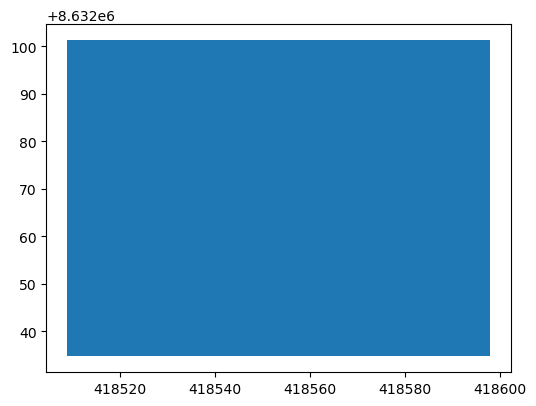

In [16]:
gdf = gpd.read_file(vect_path)
print(gdf.head)
print(gdf.crs)
gdf.plot(figsize=(6, 6))
plt.show()

Reproyectar las coordenadas del centroide que guardamos en las variables loc_cent_e y loc_cent_n, a latitud y longitud.

In [17]:
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:32718", "EPSG:4326", always_xy=True)
print(loc_cent_e, loc_cent_n)

lon, lat = transformer.transform(loc_cent_e, loc_cent_n)
print(lat, lon)

418553.52 8632067.97
-12.373163882972186 -75.74920946441908


Agregar mapas base personalizados a folium, y añadir nuestro poligono previamente leido con geopandas y reproyectado a sistema de referencia geodésico WGS84.


In [18]:
# Add custom basemaps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}


m = folium.Map(location=[lat, lon], zoom_start=20)

# Add custom basemaps
basemaps['Google Satellite'].add_to(m)

# Use WGS 84 (epsg:4326) as the geographic coordinate system
gdf = gdf.to_crs(epsg=4326)
geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j)
folium.Popup(gdf["Area"]).add_to(geo_j)
print(geo_j)

geo_j.add_to(m)

# Display the map.
display(m)

Guardar un vector tipo polígono que representa el area de la huella de la imagen en el terreno, a partir de las coordenadas proyectadas de sus vértices, basados en su orientación interna, adicionalmente obtenemos las coordenadas de su centroide que guardamos en dos variables llamadas : loc_cent_e y loc_cent_n.

In [19]:
vect_path = repo_path / 'Vector' / 'altumpt_footprint2.gpkg'
print(vect_path)
altumPT_ms.polygonFootprint(str(vect_path), crs18Sepgs, *altumPT_ms.footprintProjection(h, E, N, xgimbal, ygimbal, zgimbal))

E:\open-forestal-master\Vector\altumpt_footprint2.gpkg
Area (m**2) :  5929.624999951571
Centroids coordinates x,y :  418553.52 8632067.97


(418553.52, 8632067.97)

Visualizar en folium nuestro poligono reproyectado a sistema de referencia geodésico WGS84.

<bound method NDFrame.head of        Area                                           geometry
0  5929.625  POLYGON Z ((418497.960 8632069.734 0.000, 4185...>
EPSG:32718


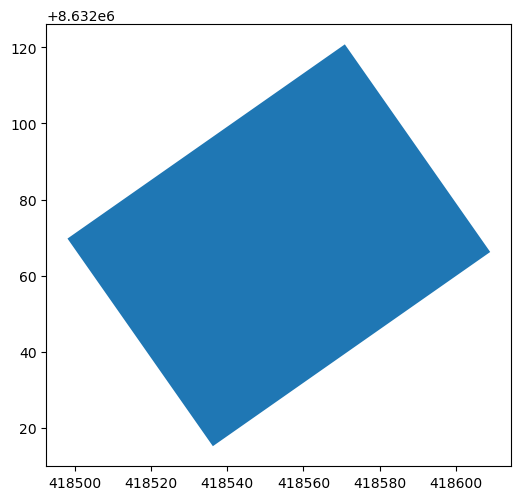

418553.52 8632067.97
-12.373163882972186 -75.74920946441908


In [20]:
gdf = gpd.read_file(vect_path)
print(gdf.head)
print(gdf.crs)
gdf.plot(figsize=(6, 6))
plt.show()

from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:32718", "EPSG:4326")
print(loc_cent_e, loc_cent_n)

lat, lon = transformer.transform(loc_cent_e, loc_cent_n)
print(lat, lon)

m = folium.Map(location=[lat, lon], zoom_start=20)

# Add custom basemaps
basemaps['Google Satellite'].add_to(m)

# Use WGS 84 (epsg:4326) as the geographic coordinate system
gdf = gdf.to_crs(epsg=4326)
geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j)
folium.Popup(gdf["Area"]).add_to(geo_j)
print(geo_j)

geo_j.add_to(m)

# Display the map.
display(m)

### Prueba de sensibilidad a la proyección de la huella

Aqui se itera sobre el el método de proyección de la huella, variando los distintos angulos de rotación, y con las coordenadas obtenidas se guarda un vector por cada iteración, estos resultados puedes ser mejor visualizados en un SIG, y asi evaluar la influencia de cada ángulo de orientación en la huella y cobertura sobre el terreno resultante.

In [21]:
for i in range(-30,40,10):
    print(i)
    salidaX = repo_path / 'Vector' / ('AltumPT_MS_' + 'roll_X' + str(i) + '.gpkg')
    altumPT_ms.polygonFootprint(str(salidaX), crs18Sepgs, *altumPT_ms.footprintProjection(h, E, N, i, ygimbal, zgimbal))
    print(salidaX)
    salidaY = repo_path / 'Vector' / ('AltumPT_MS_' + 'pitch_Y' + str(i) + '.gpkg')
    altumPT_ms.polygonFootprint(str(salidaY), crs18Sepgs, *altumPT_ms.footprintProjection(h, E, N, xgimbal, i, zgimbal))
    print(salidaY)
    salidaZ = repo_path / 'Vector' / ('AltumPT_MS_' + 'yaw_Z' + str(i) + '.gpkg')
    altumPT_ms.polygonFootprint(str(salidaZ), crs18Sepgs, *altumPT_ms.footprintProjection(h, E, N, xgimbal, ygimbal, i))
    print(salidaZ)

-30
Area (m**2) :  10465.24333512783
Centroids coordinates x,y :  418488.40005063376 8632022.372520568
E:\open-forestal-master\Vector\AltumPT_MS_roll_X-30.gpkg
Area (m**2) :  9844.063827322796
Centroids coordinates x,y :  418513.62045052735 8632124.95246205
E:\open-forestal-master\Vector\AltumPT_MS_pitch_Y-30.gpkg
Area (m**2) :  5929.625
Centroids coordinates x,y :  418553.5200000001 8632067.97
E:\open-forestal-master\Vector\AltumPT_MS_yaw_Z-30.gpkg
-20
Area (m**2) :  7536.3295090626925
Centroids coordinates x,y :  418514.5502150139 8632040.68306279
E:\open-forestal-master\Vector\AltumPT_MS_roll_X-20.gpkg
Area (m**2) :  7360.946729147807
Centroids coordinates x,y :  418529.0931790556 8632102.855115645
E:\open-forestal-master\Vector\AltumPT_MS_pitch_Y-20.gpkg
Area (m**2) :  5929.624999905005
Centroids coordinates x,y :  418553.5199999999 8632067.969999997
E:\open-forestal-master\Vector\AltumPT_MS_yaw_Z-20.gpkg
-10
Area (m**2) :  6285.461083995178
Centroids coordinates x,y :  418535.1195

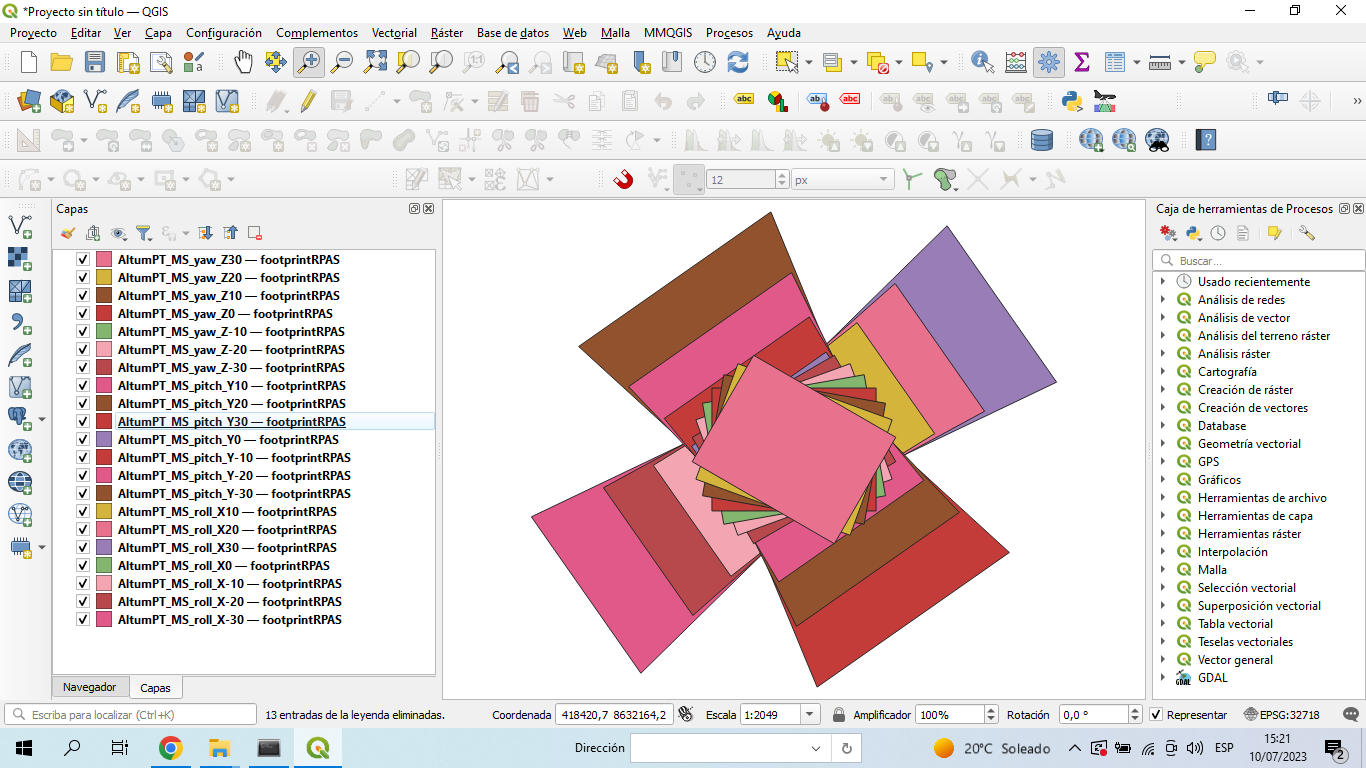

## Georreferenciación directa e indirecta

La georreferenciación directa (Direct Georeferencing - DG) se hace asequible con la disponibilidad de sensores de alta precisión y bajo costo, incluido el receptor GNSS que brinda información de posición y las unidades de medición inercial (Inertial Measurement Units - IMU) que brindan información de rotación.

La georreferenciación indirecta (Indirect Georeferencing - IG), depende principalmente de los puntos de control terrestre (Ground Control Points - GCP) que se utilizan para ayudar a la aerotriangulación (AT) en fotogrametría.

El método de proyección de la huella de la imagen (Image Footprint Projection - IFP) para la georreferenciación directa, que utiliza ecuaciones de colinealidad en cada imagen individualmente, es el más preciso y el más fácil de implementar.

Este método se aplica directamente sobre cada imagen individual, y asigna las cuatro coordenadas estimadas de los vértices como GCP, para georenfenciar la imagen, es mas adecuado para imagenes RGB, debemos tener en cuenta que no se realizaron correcciones previas a la imagen como la correccion de las distorciones del lente, o para el caso de imagenes multispectrales la calibración a reflectancia o alineación de las bandas, por lo tanto se considera como ayuda para evaluar la cobertura y superposición de las imagenes, posterior a la captura de fotos en una misión de vuelo, y previo a un procesamiento fotogramétrico más riguroso.

In [22]:
# Save footprint
rast_path = repo_path / 'Raster' / 'IMG_0054_1.tif'
altumPT_ms.GCP2imagery(str(rast_path), crs18Sepgs, *altumPT_ms.cornersCoordinates(h, E, N))

rast_path = repo_path / 'Raster' / 'IMG_0054_2.tif'
altumPT_ms.GCP2imagery(str(rast_path), crs18Sepgs, *altumPT_ms.footprintProjection(h, E, N, xgimbal, ygimbal, zgimbal))

rast_path = repo_path / 'Raster' / 'IMG_0054_3.tif'
altumPT_ms.GCP2imagery(str(rast_path), crs18Sepgs, *altumPT_ms.footprintProjection(h, E, N, 10, 10, 10))

Origin: (418509.02, 8632101.280000001)
Pixel size: (0.04312015503875969, -0.04314766839445795)
X pixel rotation: 0.0
Y pixel rotation 0.0
Origin: (418497.96046899323, 8632069.733851057)
Pixel size: (0.035321963150044246, -0.035347153464871835)
X pixel rotation: 0.024750343310805417
Y pixel rotation 0.024732704862122614
Origin: (418530.7573481234, 8632089.142158337)
Pixel size: (0.0446063186574635, -0.045054238585141106)
X pixel rotation: -0.00735920243202706
Y pixel rotation -0.00961061895107802


## Plan de vuelo

Esta clase ayuda a realizar cálculos básicos para planificar y diseñar una misión de vuelo, de acuerdo a un sensor óptico especifico, y poder crear una ruta de vuelo en base a una lista de waypoints, ya sea obtenida de los centroides de las huellas ó a partir del distancias y acimuts.

Estimar la superposición longitudinal y lateral, de acuerdo al porcentaje se solapamiento deseado, tambien el tiempo entre capturas para una velocidad de vuelo dada.

In [23]:
MS_flight_plan = fp.UAV(*altumPT_ms.gFoV(h, view=True)) # instanciar la clase para crear un objeto

PE = 80 
bh = MS_flight_plan.endlap(PE) # air base (m)
bh
bw = MS_flight_plan.sidelap(PE) # separation distance between the flight strips (m)
bw

vg = 5 # flying speed, constant ground velocity (m/s)

tl, tw =  MS_flight_plan.intervalExposure(bh, bw, vg) # time interval between exposures (s)
print(tl, tw)

*********************************** Results ***********************************
Altitude: 100 

Area (m**2): 5929.18 

Imagery Orthogonal Width (m): 89.0 
Imagery Orthogonal Height (m): 66.62
13.323999999999998
17.799999999999997
2.6647999999999996 3.5599999999999996


Generar una lista de coordenadas (waypoints), para crear una ruta de vuelo a partir de los centroides de las huellas generadas, de acuerdo al solapamiento previamente establecido. Las huellas resultantes nuevamente las podemos visualizar en el SIG.

In [24]:
# Flight path, First line, iteratively from origin
Eo = [E]
No = [N]
print(Eo, No)

# Create list of coordinates
Ex = [E]
Nx = [N]
print(Ex, Nx)

for i in range(11) :
    Eo, No = MS_flight_plan.cogo(E, N, (i*bh), zgimbal)
    vec_out = repo_path / 'Vector' / ('Altum_' + '1p' + str(i+1) + '.gpkg')
    print(vec_out)
    ex, nx = altumPT_ms.polygonFootprint(str(vec_out), crs18Sepgs, *altumPT_ms.footprintProjection(h, Eo, No, xgimbal, ygimbal, zgimbal))
    print(ex, nx)
    Ex.append(ex)
    Nx.append(nx)

[418553.52] [8632067.97]
[418553.52] [8632067.97]
-0.0 0.0
E:\open-forestal-master\Vector\Altum_1p1.gpkg
Area (m**2) :  5929.624999951571
Centroids coordinates x,y :  418553.52 8632067.97
418553.52 8632067.97
-7.642332437941342 10.914381838106522
E:\open-forestal-master\Vector\Altum_1p2.gpkg
Area (m**2) :  5929.6249999552965
Centroids coordinates x,y :  418545.87766756216 8632078.88438184
418545.87766756216 8632078.88438184
-15.284664875882685 21.828763676213043
E:\open-forestal-master\Vector\Altum_1p3.gpkg
Area (m**2) :  5929.624999953434
Centroids coordinates x,y :  418538.2353351242 8632089.798763677
418538.2353351242 8632089.798763677
-22.926997313824028 32.743145514319565
E:\open-forestal-master\Vector\Altum_1p4.gpkg
Area (m**2) :  5929.6249999552965
Centroids coordinates x,y :  418530.5930026862 8632100.713145515
418530.5930026862 8632100.713145515
-30.56932975176537 43.65752735242609
E:\open-forestal-master\Vector\Altum_1p5.gpkg
Area (m**2) :  5929.624999951571
Centroids coordin

Crear un vector tipo línea que representa la ruta de vuelo con las coordenadas previas, y guardarlo en nuestro ordenador.

In [25]:
# Save in disk
flightPath_out = repo_path / 'Vector' / 'Multiespectral_flightPath_h100.gpkg'
MS_flight_plan.flightPath(str(flightPath_out), crs18Sepgs, Ex, Nx)

418553.52 8632067.97
418553.52 8632067.97
418545.87766756216 8632078.88438184
418538.2353351242 8632089.798763677
418530.5930026862 8632100.713145515
418522.9506702483 8632111.62752735
418515.30833781033 8632122.541909192
418507.66600537236 8632133.45629103
418500.0236729344 8632144.370672869
418492.3813404965 8632155.285054706
418484.7390080585 8632166.199436544
418477.09667562065 8632177.11381838
Longitud : (m) 133.23999999783243


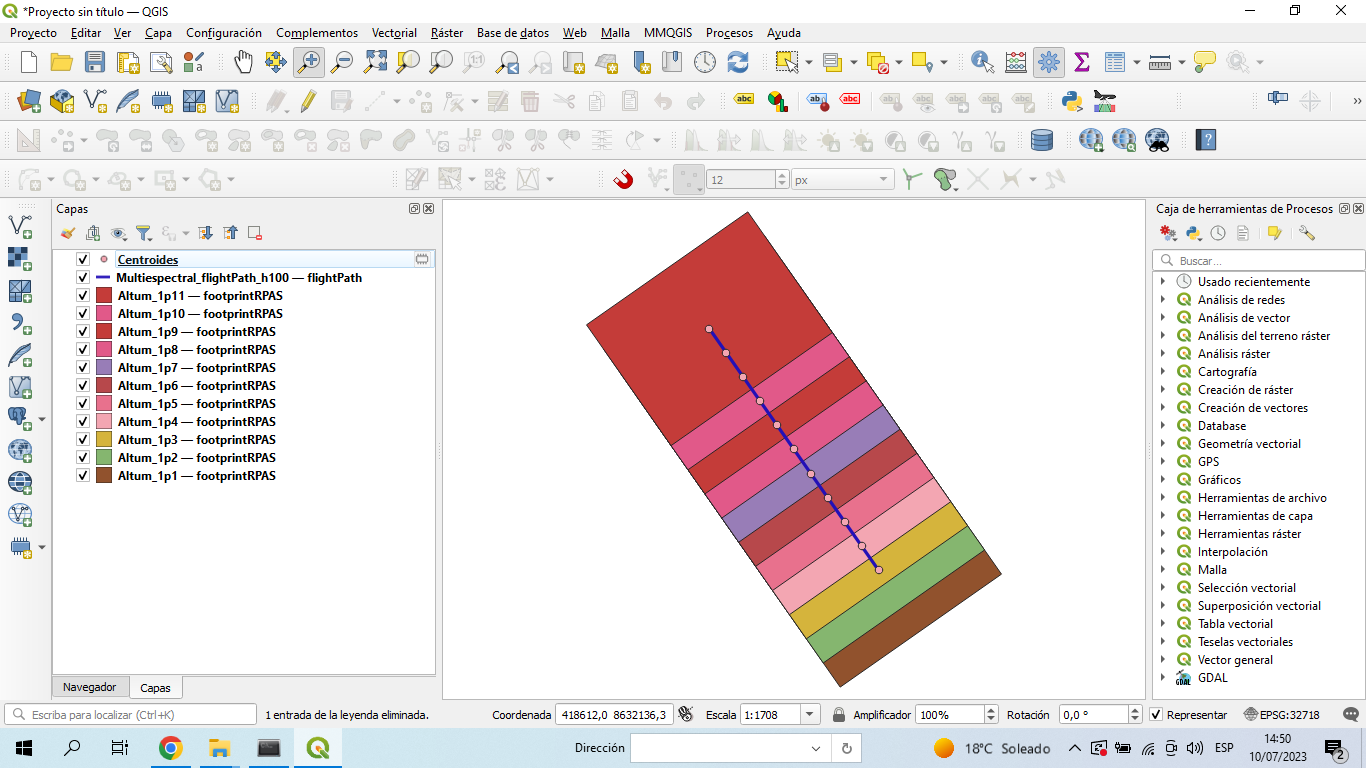

Generar una lista de coordenadas (waypoints), para crear una ruta de vuelo a partir de una coordenada de origen, distancias y acimuts, de acuerdo al solapamiento previamente establecido. El vector resultante lo podemos visualizar en el SIG.

In [26]:
# Flight path

# Create list of coordinates
Ex = [E]
Nx = [N]
print(Ex, Nx)

Eo, No = MS_flight_plan.cogo(E, N, bh * 10, zgimbal)
Ex.append(Eo)
Nx.append(No)
print(Ex, Nx)

ex, nx = MS_flight_plan.cogo(Ex[len(Ex)-1], Nx[len(Nx)-1], bw, zgimbal - 90)
print(ex, nx)
Ex.append(ex)
Nx.append(nx)
print(Ex, Nx)

ex, nx = MS_flight_plan.cogo(Ex[len(Ex)-1], Nx[len(Nx)-1], bh * 10, zgimbal - 180)
print(ex, nx)
Ex.append(ex)
Nx.append(nx)
print(Ex, Nx)

ex, nx = MS_flight_plan.cogo(Ex[len(Ex)-1], Nx[len(Nx)-1], bw, zgimbal - 90)
print(ex, nx)
Ex.append(ex)
Nx.append(nx)
print(Ex, Nx)

ex, nx = MS_flight_plan.cogo(Ex[len(Ex)-1], Nx[len(Nx)-1], bh * 10, zgimbal)
print(ex, nx)
Ex.append(ex)
Nx.append(nx)
print(Ex, Nx)

ex, nx = MS_flight_plan.cogo(Ex[len(Ex)-1], Nx[len(Nx)-1], bw, zgimbal - 90)
print(ex, nx)
Ex.append(ex)
Nx.append(nx)
print(Ex, Nx)

ex, nx = MS_flight_plan.cogo(Ex[len(Ex)-1], Nx[len(Nx)-1], bh * 10, zgimbal - 180)
print(ex, nx)
Ex.append(ex)
Nx.append(nx)
print(Ex, Nx)

ex, nx = MS_flight_plan.cogo(Ex[len(Ex)-1], Nx[len(Nx)-1], bw, zgimbal - 90)
print(ex, nx)
Ex.append(ex)
Nx.append(nx)
print(Ex, Nx)

ex, nx = MS_flight_plan.cogo(Ex[len(Ex)-1], Nx[len(Nx)-1], bh * 10, zgimbal)
print(ex, nx)
Ex.append(ex)
Nx.append(nx)
print(Ex, Nx)

# Save in disk
flightPath_out = repo_path / 'Vector' / 'Multiespectral_flightPath_FULL_h100.gpkg'
MS_flight_plan.flightPath(str(flightPath_out), crs18Sepgs, Ex, Nx)


[418553.52] [8632067.97]
-76.42332437941343 109.14381838106522
[418553.52, 418477.0966756206] [8632067.97, 8632177.113818381]
-14.580906388344047 -10.209660567048624
418462.51576923224 8632166.904157814
[418553.52, 418477.0966756206, 418462.51576923224] [8632067.97, 8632177.113818381, 8632166.904157814]
76.42332437941334 -109.14381838106527
418538.93909361167 8632057.760339433
[418553.52, 418477.0966756206, 418462.51576923224, 418538.93909361167] [8632067.97, 8632177.113818381, 8632166.904157814, 8632057.760339433]
-14.580906388344047 -10.209660567048624
418524.3581872233 8632047.550678866
[418553.52, 418477.0966756206, 418462.51576923224, 418538.93909361167, 418524.3581872233] [8632067.97, 8632177.113818381, 8632166.904157814, 8632057.760339433, 8632047.550678866]
-76.42332437941343 109.14381838106522
418447.9348628439 8632156.694497246
[418553.52, 418477.0966756206, 418462.51576923224, 418538.93909361167, 418524.3581872233, 418447.9348628439] [8632067.97, 8632177.113818381, 8632166.9

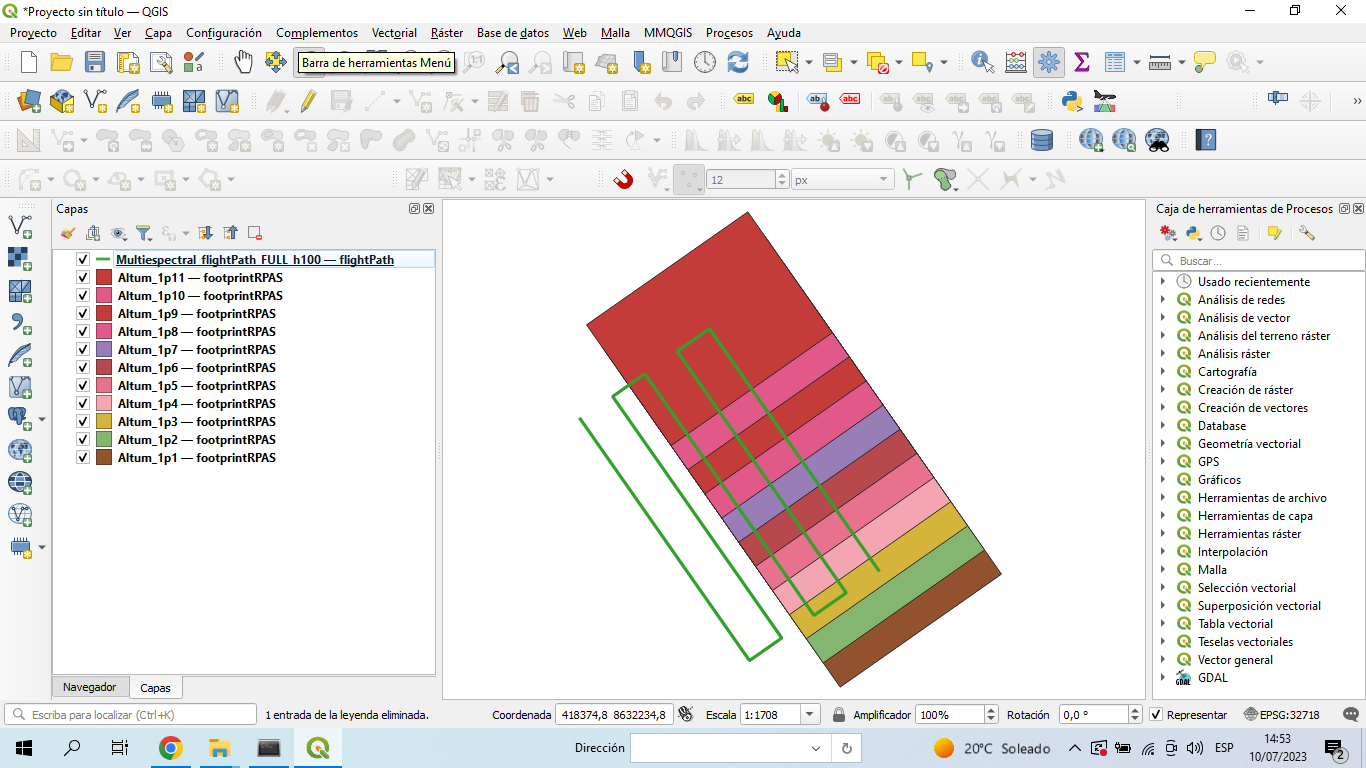